In [1]:
from import_art_stop_allyrs_v2 import import_article
import pandas as pd
import math
import os
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import numpy as np

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ankushswarnakar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def load_eng_words():
    """load_eng_words function
        @returns valid_words (set of strings): the set of string in the english words file """

    with open('/Users/ankushswarnakar/Library/Mobile Documents/com~apple~CloudDocs/Documents/Stanford/2020-2021/neural-jump/words_alpha.txt') as word_file:
        valid_words = set(word_file.read().split())
    return valid_words

In [3]:
def load_labels():
    """load_labels function
        @returns labels (dataframe of slug, label) tuples"""

    labels = pd.read_csv('/Users/ankushswarnakar/Library/Mobile Documents/com~apple~CloudDocs/Documents/Stanford/2020-2021/neural-jump/jumps_by_day.csv')
    labs = ['Corporate', 'Govspend', 'Macro', 'Monetary', 'Sovmil']
    lab_map = {name : i for i, name in enumerate(labs)} #Create dicitonary mapping labs to indices
    #print(lab_map)
    cols_to_keep = ['Date', 'Return'] + labs #specification in paper
    labels = labels[cols_to_keep]
    labels['Date'] = pd.to_datetime(labels['Date'], errors='coerce', infer_datetime_format=True)
    labels['Sum'] = labels[labs].sum(axis=1)
    labels = labels[labels['Sum'] > 0] #filters out all rows that do not have a label in labs
    labels['Max'] = labels[labs].idxmax(axis=1) #Max column has label to keep
    labels['Max'] = labels['Max'].map(lab_map)
    return labels


In [4]:
def load_articles(narts=5, nwords = 100, min_word_length = 3, filter_stop_words = True):
    """load_articles function
    @param narts (int): the number of articles to store in the labeled dataframe
    @param nwords (int): the number of words to keep in each article
    @param min_word_length (int): the minimum number of characters in a word (all words with length < min_word_length will be filtered)
    @param filter_stop_words (boolean): a flag indicating whether to filter stop_words 
    @return labeled_articles (DataFrame): a dataframe with aritcle clippings and associated labels"""
    #print('narts = ' + str(narts))
    english_words = load_eng_words()
    stop_words = set(stopwords.words('english'))
    labels = load_labels()
    print('len(labels = ' + str(len(labels)))
    #print(labels.head())
    articles = pd.DataFrame(np.zeros((narts, 2)), columns = ['Date', 'Words'])
    for i, art in enumerate(os.listdir('/Users/ankushswarnakar/Library/Mobile Documents/com~apple~CloudDocs/Documents/Stanford/2020-2021/neural-jump/WSJ_txt')):
        #print(art)
        if i > narts: break
        rawart=import_article(art, english_words, stop_words, min_word_length, filter_stop_words)
        #print(len(rawart.split(" ")))
        #print("RAW ARTICLE: " + str(rawart))
        rawart=rawart.split(" ")
        #if len(rawart) < nwords: break
        firstn = rawart[:nwords]
        firstn = " ".join(firstn) #if our input is a text with spaces
        #print(firstn)
        slug = art.split('.')[0]
        articles.loc[i] = slug, firstn
    #print(labels.head())
    articles['Date'] = articles['Date'].str.replace('_', '/')
    #print(articles['Date'])
    articles['Date'] = pd.to_datetime(articles['Date'], errors='coerce', format='%Y/%m/%d') 
    print('len(articles) = ' + str(len(articles)))
    labeled_articles = labels.merge(articles, left_on = 'Date', right_on = 'Date')
    print('len(labeled_articles) = ' + str(len(labeled_articles)))
    return labeled_articles

In [5]:
narts = 1104
nwords = 100
min_word_length = 3
filter_stop_words = True
labeled_articles = load_articles(narts, nwords, min_word_length, filter_stop_words)

len(labels = 838
len(articles) = 1104
len(labeled_articles) = 829


In [6]:
print(labeled_articles)

          Date  Return  Corporate  Govspend     Macro  Monetary  Sovmil  \
0   2018-03-22 -0.0252      0.000       0.0  0.083333  0.000000   0.000   
1   2018-02-08 -0.0375      0.000       0.0  0.583333  0.333333   0.000   
2   2018-02-05 -0.0410      0.000       0.0  0.083333  0.083333   0.000   
3   2016-06-24 -0.0357      0.000       0.0  1.000000  0.000000   0.000   
4   2016-01-13 -0.0251      0.000       0.0  0.750000  0.000000   0.000   
..         ...     ...        ...       ...       ...       ...     ...   
824 1900-04-16 -0.0443      1.000       0.0  0.000000  0.000000   0.000   
825 1900-03-12  0.0264      0.375       0.0  0.000000  0.000000   0.125   
826 1900-03-02 -0.0258      0.000       0.0  0.125000  0.000000   0.000   
827 1900-01-12  0.0262      0.000       0.0  0.000000  0.000000   1.000   
828 1900-01-02  0.0310      0.125       0.0  0.000000  0.000000   0.875   

          Sum  Max                                              Words  
0    0.083333    2  trade w

In [7]:
!pip install -U sentence-transformers


In [8]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-mean-tokens')
# sentences = ['This framework generates embeddings for each input sentence',
#     'Sentences are passed as a list of string.', 
#     'The quick brown fox jumps over the lazy dog.']
# sentence_embeddings = model.encode(sentences)

Some weights of the model checkpoint at /Users/ankushswarnakar/.cache/torch/sentence_transformers/sbert.net_models_bert-base-nli-mean-tokens/0_BERT were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
# print(sentence_embeddings)

In [10]:
article_sentences = []
for i, row in labeled_articles.iterrows():
    sentence = row['Words'].strip()
    article_sentences.append(sentence)

In [11]:
article_embeddings = model.encode(article_sentences)

In [12]:
print(article_embeddings)

[[-0.4670891   0.7597283  -0.34234613 ... -0.22197115  0.56094044
  -0.40979108]
 [-0.6770887   0.2934068  -0.0038115  ... -0.3187059   0.6825635
  -0.10460709]
 [-0.7556235   0.35623196 -0.06851063 ... -0.4651316   0.63037
  -0.11942577]
 ...
 [-0.85087     0.5897822  -0.47568858 ... -0.21504414  0.5191416
  -0.08759654]
 [-0.68870604  0.35268396 -0.77620286 ...  0.18397614  0.37774134
  -0.10537001]
 [-0.7860669   0.59846216 -0.6715907  ...  0.15633461  0.42572087
  -0.05762446]]


In [13]:
!pip3 install sklearn

In [14]:
import sklearn
from sklearn.cluster import KMeans

In [58]:
kmeans = KMeans(n_clusters=5)

In [59]:
kmeans.fit(article_embeddings)

KMeans(n_clusters=5)

In [100]:
t = kmeans.transform(article_embeddings)
total_dist = 0
for i in range(len(article_embeddings)):
    clstr = article_clusters[i]
    total_dist += t[i][clstr]
avg_dist = total_dist / len(article_embeddings)
print(avg_dist)

5.688026655424921


In [60]:
article_clusters = kmeans.predict(article_embeddings)

In [61]:
print(article_clusters)

[1 3 3 0 1 1 3 1 3 3 1 1 1 1 3 0 1 1 3 3 2 3 1 3 1 1 3 3 0 3 3 3 1 0 3 4 0
 3 3 1 1 1 0 3 3 1 3 3 1 1 1 3 1 0 1 1 3 1 1 1 1 3 3 3 3 3 1 3 0 1 3 3 3 1
 1 0 2 3 3 1 3 1 1 0 3 3 3 3 3 3 0 1 3 1 3 3 3 3 1 3 3 3 3 3 3 0 3 0 1 0 3
 3 3 3 0 1 3 0 1 1 1 3 3 2 3 3 1 0 0 0 1 0 3 1 1 0 1 0 0 1 2 1 3 3 3 3 3 4
 1 1 3 3 3 3 3 3 1 3 1 0 3 1 3 2 3 3 4 0 1 3 3 1 1 0 3 1 0 3 3 0 3 1 3 1 3
 0 3 1 1 3 3 1 0 3 2 3 0 3 0 1 1 3 1 3 3 3 0 1 1 3 1 1 3 3 0 1 0 3 0 1 3 0
 3 1 3 1 3 3 1 3 0 3 1 1 3 3 1 1 1 3 2 3 1 0 1 1 3 1 1 3 3 3 1 1 0 1 0 3 0
 3 1 1 1 3 3 2 3 1 3 1 1 1 1 3 3 1 1 1 0 0 1 1 3 0 1 1 3 1 1 3 0 1 4 3 3 1
 3 1 0 3 1 4 3 3 3 3 0 3 3 1 3 3 3 4 1 0 1 0 0 4 0 0 4 0 0 0 0 2 0 4 3 0 2
 2 0 1 2 3 0 1 2 0 0 2 4 3 2 0 2 4 0 2 2 0 2 2 2 3 2 0 2 2 1 1 2 0 0 0 2 2
 2 4 2 0 2 1 1 1 1 1 0 2 2 0 0 1 2 3 3 2 2 2 1 2 2 0 0 2 2 1 2 3 3 1 2 2 0
 0 0 3 3 2 1 0 2 0 2 2 1 3 3 2 0 2 2 3 3 2 2 2 0 3 0 3 3 3 1 3 1 2 0 1 3 1
 1 0 1 4 2 1 3 3 2 4 1 3 3 4 3 2 2 0 0 1 0 2 2 1 1 2 4 1 1 1 3 2 1 1 3 2 4
 4 4 3 4 1 0 0 0 0 4 1 4 

In [62]:
groups = [[] for _ in range(5)]

In [20]:
print(groups)

[[], [], [], [], [], []]


In [63]:
n = len(article_embeddings)

for i in range(n):
    cluster = article_clusters[i]
    groups[cluster].append(article_sentences[i])

In [64]:
def ngrams(input, n):
    input = input.split(' ')
    output = []
    for i in range(len(input)-n+1):
        output.append(input[i:i+n])
    return output

In [65]:
from collections import Counter
from nltk.stem.snowball import SnowballStemmer

In [68]:
gram_size = 2
stemmer = SnowballStemmer("english")
cluster_top_bigrams = [[] for _ in range(6)]
for i in range(5):
#     print("Cluster " + str(i))
    group_ngrams = []
    for sentence in groups[i]:
        gram_list = ngrams(sentence, gram_size)
        for gram in gram_list:
#             gram = [stemmer.stem(w) for w in gram]
            group_ngrams.append(' '.join(gram))
    c = Counter(group_ngrams)
    for (s, ct) in c.most_common(50):
        cluster_top_bigrams[i].append(s)
#         print(s)
# #     print(c.most_common(10))
#     print("\n")

In [70]:
# filter out bigrams present in > 3 sets
cluster_top_bigrams_set = [set(l) for l in cluster_top_bigrams]
import itertools
common_bigrams = set()
for i, j, k in itertools.combinations(range(6), 3):
    intersect = cluster_top_bigrams_set[i] & cluster_top_bigrams_set[j] & cluster_top_bigrams_set[k]
    for bigram in intersect:
        common_bigrams.add(bigram)

In [71]:
print(common_bigrams)

{'new low', 'last week', 'steel common', 'bank rate', 'stock prices', 'new lows', 'stock exchange', 'made new', 'new high', 'general motors', 'call money', 'new york', 'money renewal', 'interest rates', 'bond market', 'federal reserve', 'industrial average', 'market diary', 'wall street', 'york bank', 'stock market', 'york stock'}


In [73]:
for i in range(5):
    print("Cluster " + str(i) +" top bigrams:")
    ct = 0
    j = 0
    while (ct < 15) and j < len(cluster_top_bigrams[i]):
        if cluster_top_bigrams[i][j] not in common_bigrams:
            print(cluster_top_bigrams[i][j])
            ct += 1
        j += 1
    print("\n")
        
#     useful_bigrams = set(cluster_top_bigrams[i]).difference(common_bigrams)
# #     print(useful_bigrams)
#     print(list(useful_bigrams)[:15])

Cluster 0 top bigrams:
heavy selling
took place
united states
last hour
york central
bank america
financial markets
lower prices
rate cut
stop orders
sales shares
short covering
market yesterday
leading issues
leading stocks


Cluster 1 top bigrams:
one day
composite index
new highs
stock index
gain since
rose points
percentage gain
standard poor
poor stock
biggest gain
points biggest
blue chip
bank america
jumped points
average rose


Cluster 2 top bigrams:
union pacific
new highs
united states
york central
short covering
early dealings
stocks made
previous day
good deal
points rails
short interest
states steel
london market
industrial averages
points utilities


Cluster 3 top bigrams:
bear market
fell points
standard poor
stock index
lowest level
one day
lowest close
poor stock
average fell
close since
composite index
index fell
blue chip
level since
dow industrials


Cluster 4 top bigrams:
previous closing
stock averages
diary stock
closing average
complete tabulation
figured previo

In [76]:
most_common_words = set()
words = []
for group in groups:
    for sentence in group:
        sentence = sentence.strip().split()
        for word in sentence: 
            words.append(word)
c = Counter(words)
most_common_words = set([s for (s, _) in c.most_common(30)])

In [77]:
print(most_common_words)

{'one', 'bank', 'steel', 'close', 'last', 'york', 'stock', 'since', 'news', 'day', 'average', 'shares', 'decline', 'industrials', 'week', 'selling', 'issues', 'year', 'yesterday', 'time', 'low', 'industrial', 'market', 'stocks', 'trading', 'prices', 'markets', 'investors', 'new', 'points'}


In [79]:
for i in range(5):
    print("Cluster " + str(i) +" top bigrams:")
    useful_bigrams = set()
    for bigram in cluster_top_bigrams[i]:
        [w1, w2] = bigram.split()
        if not (w1 in most_common_words or w2 in most_common_words):
            useful_bigrams.add(bigram)
    print(useful_bigrams)

Cluster 0 top bigrams:
{'united states', 'southern pacific', 'stop orders', 'wall street', 'interest rates', 'recent weeks', 'took place', 'buying orders', 'general list', 'federal reserve', 'short covering', 'great britain', 'resistance levels', 'general motors', 'call money', 'rate cut'}
Cluster 1 top bigrams:
{'money renewal', 'blue chip', 'blue chips', 'wall street', 'profit taking', 'interest rates', 'composite index', 'point gain', 'first hour', 'percentage gain', 'federal reserve', 'standard poor', 'biggest gain', 'general motors', 'gain ever', 'call money'}
Cluster 2 top bigrams:
{'commission houses', 'took place', 'short covering', 'union pacific', 'increased earnings', 'first hour', 'general list', 'general motors', 'early afternoon', 'call money', 'money renewal', 'rails utilities', 'half hour', 'good deal', 'best levels', 'federal reserve', 'short interest', 'main body', 'united states', 'early dealings', 'wall street', 'profit taking'}
Cluster 3 top bigrams:
{'blue chip', 

In [169]:
# get human label means 
# 0 corporate
# 1 Govspend
# 2 Macro
# 3 Monetary
# 4 Sovmil

lbls = ['Corporate', 'Govspend', 'Macro', 'Monetary', 'Sovmil']
labels = []
for _, row in labeled_articles.iterrows():
    label = np.argmax([row[lbl] for lbl in lbls])
    labels.append(label)

In [95]:
h_groups = [[] for _ in range(5)]
h_groups_embeddings = [[] for _ in range(5)]

In [98]:
for i in range(len(article_sentences)):
    label = labels[i]
    sentence = article_sentences[i]
    embedding = article_embeddings[i]
    h_groups[label].append(sentence)
    h_groups_embeddings[label].append(embedding)

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [122]:
print(np.mean(h_groups_embeddings[0], axis=0).shape)

h_group_means = [np.mean(h_groups_embeddings[i], axis=0) for i in range(5)]
# h_groups_embeddings = np.array([np.array(h_group_embeddings) for h_group_embeddings in h_groups_embeddings])
# # h_groups_embeddings = np.array(h_groups_embeddings)
# print(h_groups_embeddings.shape)

# print(h_group_means)

(768,)


In [112]:
print(h_group_means[1].shape)

(768,)


In [123]:
total_dist2 = 0
for i in range(5):
    for embedding in h_groups_embeddings[i]:
        total_dist2 += np.linalg.norm(embedding - h_group_means[i])
avg_dist2 = total_dist2 / len(article_embeddings)
print(avg_dist2)
        

6.386592327469939


In [124]:
kmeans_centers = kmeans.cluster_centers_

In [126]:
for i in range(5):
    human_label = lbls[i]
    dists = []
    for j in range(5):
        dists.append(np.linalg.norm(h_group_means[i] - kmeans_centers[j]))
#     print(dists)
    nearest = np.argmin(dists)
    print("Human label " + human_label + " is closest to cluster " + str(nearest))

Human label Corporate is closest to cluster 0
Human label Govspend is closest to cluster 4
Human label Macro is closest to cluster 0
Human label Monetary is closest to cluster 1
Human label Sovmil is closest to cluster 0


In [128]:
n = len(article_embeddings)
d = len(article_embeddings[0])
X = np.zeros((n, d))
for i in range(n): X[i] = article_embeddings[i]


In [131]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
reduced_X = pca.fit_transform(X)


(829, 2)


In [157]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib import cm

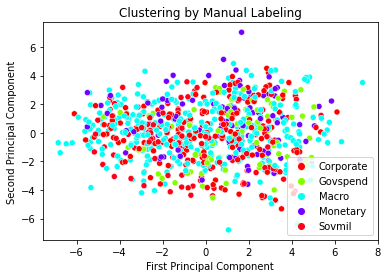

In [171]:
# fig, ax = plt.subplots()

# scatter = ax.scatter(reduced_X[:,0], reduced_X[:, 1], c=labels, marker='.')
# ax.legend(lbls)
# # legend1 = ax.legend(lbls,
# #                     loc="lower left", title="Classes")
# # ax.add_artist(legend1)
# plt.title('Clustering by Manual Labeling')
# plt.xlabel('First Principal Component')
# plt.ylabel('Second Principal Component')
# ax.legend()

ax = sns.scatterplot(x=reduced_X[:,0], y=reduced_X[:, 1], hue=labels, palette=cm.get_cmap('hsv'))
handles, _  =  ax.get_legend_handles_labels()
ax.legend(handles, lbls, loc='lower right')
plt.title('Clustering by Manual Labeling')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.savefig('manual_clustering.png')

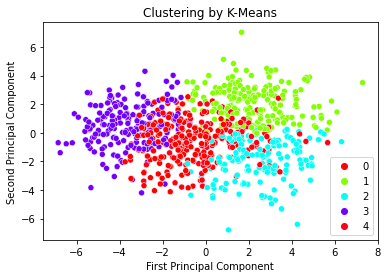

In [172]:
ax = sns.scatterplot(x=reduced_X[:,0], y=reduced_X[:, 1], hue=article_clusters, palette=cm.get_cmap('hsv'))
handles, ls  =  ax.get_legend_handles_labels()
ax.legend(handles, ls, loc='lower right')
plt.title('Clustering by K-Means')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.savefig('kmeans_clustering.png')